<a href="https://colab.research.google.com/github/sednabcn/Python-NLTK/blob/master/week2_NER_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognize named entities on Twitter with LSTMs

In this assignment, you will use a recurrent neural network to solve Named Entity Recognition (NER) problem. NER is a common task in natural language processing systems. It serves for extraction such entities from the text as persons, organizations, locations, etc. In this task you will experiment to recognize named entities from Twitter.

For example, we want to extract persons' and organizations' names from the text. Than for the input text:

    Ian Goodfellow works for Google Brain

a NER model needs to provide the following sequence of tags:

    B-PER I-PER    O     O   B-ORG  I-ORG

Where *B-* and *I-* prefixes stand for the beginning and inside of the entity, while *O* stands for out of tag or no tag. Markup with the prefix scheme is called *BIO markup*. This markup is introduced for distinguishing of consequent entities with similar types.

A solution of the task will be based on neural networks, particularly, on Bi-Directional Long Short-Term Memory Networks (Bi-LSTMs).

### Libraries

For this task you will need the following libraries:
 - [Tensorflow](https://www.tensorflow.org) — an open-source software library for Machine Intelligence.
 - [Numpy](http://www.numpy.org) — a package for scientific computing.
 
If you have never worked with Tensorflow, you would probably need to read some tutorials during your work on this assignment, e.g. [this one](https://www.tensorflow.org/tutorials/recurrent) could be a good starting point. 

### Data

The following cell will download all data required for this assignment into the folder `week2/data`.

In [0]:
import sys
#!git clone https://github.com/hse-aml/natural-language-processing
sys.path.append("/content/natural-language-processing")
sys.path.append("/content/natural-language-processing/week1")
sys.path.append("/content/natural-language-processing/week2")


### Load the Twitter Named Entity Recognition corpus

We will work with a corpus, which contains tweets with NE tags. Every line of a file contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace. Different tweets are separated by an empty line.

The function *read_data* reads a corpus from the *file_path* and returns two lists: one with tokens and one with the corresponding tags. You need to complete this function by adding a code, which will replace a user's nickname to `<USR>` token and any URL to `<URL>` token. You could think that a URL and a nickname are just strings which start with *http://* or *https://* in case of URLs and a *@* symbol for nicknames.

In [0]:
from common.download_utils import download_week2_resources

download_week2_resources()

File data/train.txt is already downloaded.
File data/validation.txt is already downloaded.
File data/test.txt is already downloaded.


And now we can load three separate parts of the dataset:
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [0]:
import re
import collections
REPLACE_BY_URL_TOKEN=re.compile("^https?://.*$")
REPLACE_BY_USR_TOKEN=re.compile("^@.*$")
def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
           
            # Replace all users with <USR> token
            
            ######################################
            ######### YOUR CODE HERE #############
            token=REPLACE_BY_URL_TOKEN.sub('<URL>',token)
            token=REPLACE_BY_USR_TOKEN.sub('<USR>',token)
            ######################################
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

In [0]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

You should always understand what kind of data you deal with. For this purpose, you can print the data running the following cell:

In [0]:
for i in range(3):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Prepare dictionaries

To train a neural network, we will use two mappings: 
- {token}$\to${token id}: address the row in embeddings matrix for the current token;
- {tag}$\to${tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

Now you need to implement the function *build_dict* which will return {token or tag}$\to${index} and vice versa. 

In [0]:
special_tokens=['<UNK>','<PAD>']
list_tokens=[tok for sent in train_tokens + validation_tokens for tok in sent]
f=lambda x:{x:list_tokens.index(x)+len(special_tokens)}
vocab=list(map(f,list_tokens))
from nltk.probability import FreqDist
words_tokens=FreqDist([word for word in list_tokens])
print(len(vocab),len(words_tokens))

112095 20503


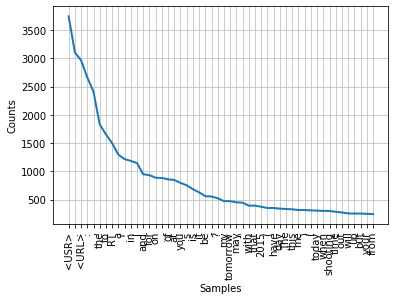

In [0]:
import matplotlib.pyplot as plt 
words_tokens.plot(50)
plt.show()

In [0]:
print(sorted(words_tokens.items(),key=lambda x:x[1],reverse=False))

[('Ghostland', 1), ('Observatory', 1), ('MacBook', 1), ('A1278', 1), ('13.3', 1), ('Laptop', 1), ('MD101LL/A', 1), ('s.w.t', 1), ('quest', 1), ('thur', 1), ('perception', 1), ('differ', 1), ('Selma', 1), ('iow', 1), ('7in', 1), ('pooky', 1), ('TL_jp', 1), ('Wie', 1), ('staat', 1), ('daar', 1), ('microfoon', 1), ('Pioneers', 1), ('unwrapping', 1), ('ensure', 1), ("Hadn't", 1), ('oily', 1), ('unstable', 1), ('self-esteem', 1), ('ambulances', 1), ('KWTX', 1), ('CBS-TV', 1), ('#FortHood', 1), ('#4GElite2', 1), ('Premium', 1), ('Budget', 1), ('Promising', 1), ('ELITE', 1), ('Launch', 1), ('rim', 1), ('teller', 1), ('#LASD', 1), ('Arson/Explosives', 1), ('Detail', 1), ('Bomb', 1), ('Squad', 1), ('Maunalua', 1), ('Noon', 1), ('Mean', 1), ('Global', 1), ('Retail', 1), ('#socialmedia', 1), ('#happening', 1), ('AKO', 1), ('EXAM', 1), ('KAMI', 1), ('MAGKASUNOD', 1), ('SUBJECT', 1), ('SECOND', 1), ('PERIOD', 1), ('#ALDUBSaveMaine', 1), ('Somerset', 1), ('7-1', 1), ('#GetPatriotic', 1), ('#MASHABLE

In [0]:
from collections import defaultdict
tok2idx=defaultdict(lambda:0)
for word in words_tokens.keys():
    tok2idx[word]=f(word)[word]

In [0]:
tok2idx.update({'<UNK>':0})
tok2idx.update({'<PAD>':1})

In [0]:
special_tokens=['O']
list_tokens=[tok for sent in train_tags + validation_tags for tok in sent]
f=lambda x:{x:list_tokens.index(x)+len(special_tokens)}
vocab=list(map(f,list_tokens))
from nltk.probability import FreqDist
tag_tokens=FreqDist([word for word in list_tokens])
print(len(vocab),len(words_tokens))

112095 20503


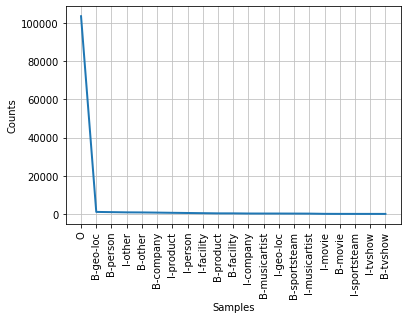

In [0]:
tag_tokens.plot(50)
plt.show()

In [0]:
from collections import defaultdict
tag2idx=defaultdict(lambda:0)
for word in tag_tokens.keys():
    tag2idx[word]=f(word)[word]
tag2idx.update({'O':0})

In [0]:
sorted(tag2idx.items(),key=lambda x:x[1],reverse=False)

[('O', 0),
 ('B-musicartist', 8),
 ('I-musicartist', 9),
 ('B-product', 27),
 ('I-product', 28),
 ('B-company', 45),
 ('B-person', 53),
 ('B-other', 166),
 ('I-other', 167),
 ('B-facility', 242),
 ('I-facility', 243),
 ('B-sportsteam', 421),
 ('B-geo-loc', 595),
 ('I-geo-loc', 613),
 ('I-company', 629),
 ('I-person', 945),
 ('B-movie', 947),
 ('I-movie', 948),
 ('B-tvshow', 4696),
 ('I-tvshow', 4697),
 ('I-sportsteam', 9722)]

In [0]:
from collections import defaultdict
from nltk.probability import FreqDist

In [0]:
def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = {}
    # Create mappings from tokens (or tags) to indices and vice versa.
    list_tokens_or_tags=[tok for sent in tokens_or_tags for tok in sent]
    # At first, add special tokens (or tags) to the dictionaries.
    # The first special token must have index 0.
    for word in special_tokens:
        tok2idx[word]=special_tokens.index(word)
    # Mapping tok2idx should contain each token or tag only once. 
    # To do so, you should:
    # 1. extract unique tokens/tags from the tokens_or_tags variable, which is not
    #    occur in special_tokens (because they could have non-empty intersection)
    
    words_tokens_or_tags=FreqDist([word for word in list_tokens_or_tags if word not in special_tokens])
    words_tokens_or_tags.most_common()
    # 2. index them (for example, you can add them into the list idx2tok
    # 3. for each token/tag save the index into tok2idx).
    
    list_words=[words for words in words_tokens_or_tags.keys()]
    f=lambda x:{x:list_words.index(x)+len(special_tokens)}
    for word in words_tokens_or_tags.keys():
        tok2idx[word]=f(word)[word]
    ######################################
    ######### YOUR CODE HERE #############
    
    for k,v in tok2idx.items():
         idx2tok.update({v:k})
    return tok2idx, idx2tok

After implementing the function *build_dict* you can make dictionaries for tokens and tags. Special tokens in our case will be:
 - `<UNK>` token for out of vocabulary tokens;
 - `<PAD>` token for padding sentence to the same length when we create batches of sentences.

In [0]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

In [0]:
n_tags=len(tag2idx.keys())
print(n_tags)

21


In [0]:
max_len=max([len(sent) for sent in train_tokens + validation_tokens])
print(max_len)

41


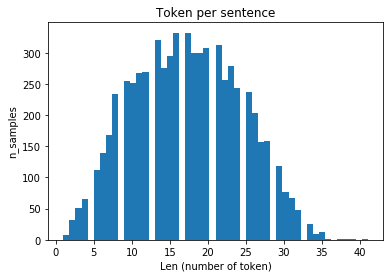

In [0]:
import matplotlib.pyplot as plt
plt.hist([len(sent) for sent in train_tokens + validation_tokens],bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('n_samples')
plt.show()

In [0]:
sequence_len=41

The next additional functions will help you to create the mapping between tokens and ids for a sentence. 

In [0]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

### Generate batches

Neural Networks are usually trained with batches. It means that weight updates of the network are based on several sequences at every single time. The tricky part is that all sequences within a batch need to have the same length. So we will pad them with a special `<PAD>` token. It is also a good practice to provide RNN with sequence lengths, so it can skip computations for padding parts. We provide the batching function *batches_generator* readily available for you to save time. 

In [0]:
def batches_generator(batch_size, tokens, tags,
                      shuffle=True, allow_smaller_last_batch=True):
    """Generates padded batches of tokens and tags."""
    
    n_samples = len(tokens)
    if shuffle:
        order = np.random.permutation(n_samples)
    else:
        order = np.arange(n_samples)

    n_batches = n_samples // batch_size
    if allow_smaller_last_batch and n_samples % batch_size:
        n_batches += 1

    for k in range(n_batches):
        batch_start = k * batch_size
        batch_end = min((k + 1) * batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        x_list = []
        y_list = []
        max_len_token = 0
        for idx in order[batch_start: batch_end]:
            x_list.append(words2idxs(tokens[idx]))
            y_list.append(tags2idxs(tags[idx]))
            max_len_token = max(max_len_token, len(tags[idx]))
            
        # Fill in the data into numpy nd-arrays filled with padding indices.
        x = np.ones([current_batch_size, max_len_token], dtype=np.int32) * token2idx['<PAD>']
        y = np.ones([current_batch_size, max_len_token], dtype=np.int32) * tag2idx['O']
        lengths = np.zeros(current_batch_size, dtype=np.int32)
        for n in range(current_batch_size):
            utt_len = len(x_list[n])
            x[n, :utt_len] = x_list[n]
            lengths[n] = utt_len
            y[n, :utt_len] = y_list[n]
        yield x, y, lengths

## Build a recurrent neural network

This is the most important part of the assignment. Here we will specify the network architecture based on TensorFlow building blocks. It's fun and easy as a lego constructor! We will create an LSTM network which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM). Dense layer will be used on top to perform tag classification.  

In [0]:
import tensorflow as tf
#!pip install --upgrade numpy 
import numpy as np
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
print(tf.__version__)

1.15.0


In [0]:
class BiLSTMModel():
    pass

First, we need to create [placeholders](https://www.tensorflow.org/api_docs/python/tf/compat/v1/placeholder) to specify what data we are going to feed into the network during the execution time.  For this task we will need the following placeholders:
 - *input_batch* — sequences of words (the shape equals to [batch_size, sequence_len]);
 - *ground_truth_tags* — sequences of tags (the shape equals to [batch_size, sequence_len]);
 - *lengths* — lengths of not padded sequences (the shape equals to [batch_size]);
 - *dropout_ph* — dropout keep probability; this placeholder has a predefined value 1;
 - *learning_rate_ph* — learning rate; we need this placeholder because we want to change the value during training.

It could be noticed that we use *None* in the shapes in the declaration, which means that data of any size can be feeded. 

You need to complete the function *declare_placeholders*.

In [0]:
def declare_placeholders(self):
    """Specifies placeholders for the model."""
    
    # Placeholders for input and ground truth output.
    self.input_batch = tf.placeholder(dtype=tf.int32, shape=[None,None], name='input_batch') 
    #self.ground_truth_tags = ######### YOUR CODE HERE #############
    self.ground_truth_tags = tf.placeholder(dtype=tf.int32,shape=[None,None],name='ground_truth_tags')
    # Placeholder for lengths of the sequences.
    self.lengths = tf.placeholder(dtype=tf.int32, shape=[None], name='lengths') 
    
    # Placeholder for a dropout keep probability. If we don't feed
    # a value for this placeholder, it will be equal to 1.0.
    dropout_ph=tf.cast(1.0, tf.float32)
    self.dropout_ph = tf.placeholder_with_default(dropout_ph, shape=[])
    
    # Placeholder for a learning rate (tf.float32).
    #self.learning_rate_ph = ######### YOUR CODE HERE #############
    self.learning_rate_ph = tf.placeholder(dtype=tf.float32,shape=[], name='learning_rate_ph')
    #

In [0]:
BiLSTMModel.__declare_placeholders = classmethod(declare_placeholders)

Now, let us specify the layers of the neural network. First, we need to perform some preparatory steps: 
 
- Create embeddings matrix with [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable). Specify its name (*embeddings_matrix*), type  (*tf.float32*), and initialize with random values.
- Create forward and backward LSTM cells. TensorFlow provides a number of RNN cells ready for you. We suggest that you use *LSTMCell*, but you can also experiment with other types, e.g. GRU cells. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) blogpost could be interesting if you want to learn more about the differences.
- Wrap your cells with [DropoutWrapper](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper). Dropout is an important regularization technique for neural networks. Specify all keep probabilities using the dropout placeholder that we created before.
 
After that, you can build the computation graph that transforms an input_batch:

- [Look up](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) embeddings for an *input_batch* in the prepared *embedding_matrix*.
- Pass the embeddings through [Bidirectional Dynamic RNN](https://www.tensorflow.org/api_docs/python/tf/nn/bidirectional_dynamic_rnn) with the specified forward and backward cells. Use the lengths placeholder here to avoid computations for padding tokens inside the RNN.
- Create a dense layer on top. Its output will be used directly in loss function.  
 
Fill in the code below. In case you need to debug something, the easiest way is to check that tensor shapes of each step match the expected ones. 
 

In [0]:
def build_layers(self, vocabulary_size, embedding_dim, n_hidden_rnn, n_tags):
    """Specifies bi-LSTM architecture and computes logits for inputs."""
    
    # Create embedding variable (tf.Variable) with dtype tf.float32
    initial_embedding_matrix = np.random.randn(vocabulary_size, embedding_dim) / np.sqrt(embedding_dim)
    #print(initial_embedding_matrix.shape)
    #embedding_matrix_variable = ######### YOUR CODE HERE ###########
    embedding_matrix_variable=tf.Variable(initial_embedding_matrix,dtype=tf.float32)
    #print(embedding_matrix_variable.shape)
    # Create RNN cells (for example, tf.nn.rnn_cell.BasicLSTMCell) with n_hidden_rnn number of units 
    # and dropout (tf.nn.rnn_cell.DropoutWrapper), initializing all *_keep_prob with dropout placeholder.
    
    #forward_cell =  ######### YOUR CODE HERE #############
    forward_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden_rnn)
    #forward_cell = tf.keras.layers.LSTMCell(n_hidden_rnn)
    forward_cell =tf.nn.rnn_cell.DropoutWrapper(forward_cell,input_keep_prob=self.dropout_ph)
    
    #backward_cell =  ######### YOUR CODE HERE #############
    backward_cell =tf.nn.rnn_cell.BasicLSTMCell(n_hidden_rnn)
    #backward_cell = tf.keras.layers.LSTMCell(n_hidden_rnn)
    backward_cell =tf.nn.rnn_cell.DropoutWrapper(backward_cell,output_keep_prob=self.dropout_ph)

    # Look up embeddings for self.input_batch (tf.nn.embedding_lookup).
    # Shape: [batch_size, sequence_len, embedding_dim].
    #embeddings =  ######### YOUR CODE HERE #############
    embeddings = tf.nn.embedding_lookup(embedding_matrix_variable,self.input_batch)
    #print(embeddings.shape)
    #print(input())
    # Pass them through Bidirectional Dynamic RNN (tf.nn.bidirectional_dynamic_rnn).
    # Shape: [batch_size, sequence_len, 2 * n_hidden_rnn]. 
    # Also don't forget to initialize sequence_length as self.lengths and dtype as tf.float32.
    #(rnn_output_fw, rnn_output_bw), _ =  ######### YOUR CODE HERE #############
    
    (rnn_output_fw, rnn_output_bw), _ = \
    tf.nn.bidirectional_dynamic_rnn( \
        cell_fw=forward_cell,cell_bw=backward_cell, inputs=embeddings,sequence_length=self.lengths,dtype=tf.float32)
    
    rnn_output = tf.concat([rnn_output_fw, rnn_output_bw], axis=2)
    #rnn_output = tf.cast(rnn_output,tf.float32) 
    # Dense layer on top.
    # Shape: [batch_size, sequence_len, n_tags].   
    self.logits = tf.layers.dense(rnn_output, n_tags, activation=None)

In [0]:
BiLSTMModel.__build_layers = classmethod(build_layers)

To compute the actual predictions of the neural network, you need to apply [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) to the last layer and find the most probable tags with [argmax](https://www.tensorflow.org/api_docs/python/tf/argmax).

In [0]:
def compute_predictions(self):
    """Transforms logits to probabilities and finds the most probable tags."""
    
    # Create softmax (tf.nn.softmax) function
    #softmax_output = ######### YOUR CODE HERE #############
    softmax_output =tf.nn.softmax(self.logits, axis=-1,name=None)
    # Use argmax (tf.argmax) to get the most probable tags
    # Don't forget to set axis=-1
    try:
        argmax=tf.argmax(softmax_output,axis=-1)
    except:
        # otherwise argmax will be calculated in a wrong way
        pass
    #self.predictions = ######### YOUR CODE HERE #############
    self.predictions = argmax

In [0]:
BiLSTMModel.__compute_predictions = classmethod(compute_predictions)

During training we do not need predictions of the network, but we need a loss function. We will use [cross-entropy loss](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy), efficiently implemented in TF as 
[cross entropy with logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2). Note that it should be applied to logits of the model (not to softmax probabilities!). Also note,  that we do not want to take into account loss terms coming from `<PAD>` tokens. So we need to mask them out, before computing [mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean).

In [0]:
def compute_loss(self, n_tags, PAD_index):
    """Computes masked cross-entopy loss with logits."""
    
    # Create cross entropy function function (tf.nn.softmax_cross_entropy_with_logits_v2)
    ground_truth_tags_one_hot = tf.one_hot(self.ground_truth_tags, n_tags)
    #loss_tensor =  ######### YOUR CODE HERE #############
    loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(ground_truth_tags_one_hot, self.logits)
    mask = tf.cast(tf.not_equal(self.input_batch, PAD_index), tf.float32)
    # Create loss function which doesn't operate with <PAD> tokens (tf.reduce_mean)
    # Be careful that the argument of tf.reduce_mean should be
    # multiplication of mask and loss_tensor.
    #self.loss =  ######### YOUR CODE HERE #############
    self.loss = tf.reduce_mean(mask*loss_tensor)

In [0]:
BiLSTMModel.__compute_loss = classmethod(compute_loss)

The last thing to specify is how we want to optimize the loss. 
We suggest that you use [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) optimizer with a learning rate from the corresponding placeholder. 
You will also need to apply clipping to eliminate exploding gradients. It can be easily done with [clip_by_norm](https://www.tensorflow.org/api_docs/python/tf/clip_by_norm) function. 

def perform_optimization(self):
    """Specifies the optimizer and train_op for the model."""
    
    # Create an optimizer (tf.train.AdamOptimizer)
    #self.optimizer =  ######### YOUR CODE HERE #############
    self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate_ph)
    self.grads_and_vars = self.optimizer.compute_gradients(self.loss)  
    # Gradient clipping (tf.clip_by_norm) for self.grads_and_vars
    # Pay attention that you need to apply this operation only for gradients 
    # because self.grads_and_vars also contains variables.
    # list comprehension might be useful in this case.
    clip_norm = tf.cast(1.0, tf.float32)
    #self.grads_and_vars =  ######### YOUR CODE HERE #############
    self.grads_and_vars = tf.clip_by_norm(self.grads_and_vars, clip_norm,axes=None, name=None)
    self.train_op = self.optimizer.apply_gradients(self.grads_and_vars)

In [0]:
def perform_optimization(self):
    """Specifies the optimizer and train_op for the model."""
    
    # Create an optimizer (tf.train.AdamOptimizer)
   
    self.train_op = tf.train.AdamOptimizer(learning_rate = self.learning_rate_ph).minimize(self.loss)

In [0]:
BiLSTMModel.__perform_optimization = classmethod(perform_optimization)

Congratulations! You have specified all the parts of your network. You may have noticed, that we didn't deal with any real data yet, so what you have written is just recipes on how the network should function.
Now we will put them to the constructor of our Bi-LSTM class to use it in the next section. 

In [0]:
def init_model(self, vocabulary_size, n_tags, embedding_dim, n_hidden_rnn, PAD_index):
    self.__declare_placeholders()
    self.__build_layers(vocabulary_size, embedding_dim, n_hidden_rnn, n_tags)
    self.__compute_predictions()
    self.__compute_loss(n_tags, PAD_index)
    self.__perform_optimization()

## Train the network and predict tags

[Session.run](https://www.tensorflow.org/api_docs/python/tf/Session#run) is a point which initiates computations in the graph that we have defined. To train the network, we need to compute *self.train_op*, which was declared in *perform_optimization*. To predict tags, we just need to compute *self.predictions*. Anyway, we need to feed actual data through the placeholders that we defined before. 

In [0]:
BiLSTMModel.__init__ = classmethod(init_model)

In [0]:
def train_on_batch(self, session, x_batch, y_batch, lengths, learning_rate, dropout_keep_probability):
    feed_dict = {self.input_batch: x_batch,
                 self.ground_truth_tags: y_batch,
                  self.lengths: lengths,
                 self.learning_rate_ph: learning_rate,
                 self.dropout_ph: dropout_keep_probability}
    
    session.run(self.train_op, feed_dict=feed_dict)

In [0]:
BiLSTMModel.train_on_batch = classmethod(train_on_batch)

Implement the function *predict_for_batch* by initializing *feed_dict* with input *x_batch* and *lengths* and running the *session* for *self.predictions*.

In [0]:
def predict_for_batch(self, session, x_batch, lengths):
    ######################################
    ######### YOUR CODE HERE ############
    ######################################
    #print(x_batch,lengths)
    #print("======to==argmax===")
    feed_dict={self.input_batch:x_batch,
               self.lengths:lengths}
    predictions=session.run(self.predictions,feed_dict=feed_dict)
    return predictions

In [0]:
BiLSTMModel.predict_for_batch = classmethod(predict_for_batch)

We finished with necessary methods of our BiLSTMModel model and almost ready to start experimenting.

### Evaluation 
To simplify the evaluation process we provide two functions for you:
 - *predict_tags*: uses a model to get predictions and transforms indices to tokens and tags;
 - *eval_conll*: calculates precision, recall and F1 for the results.

In [0]:
from evaluation import precision_recall_f1

In [0]:
def predict_tags(model, session, token_idxs_batch, lengths):
    """Performs predictions and transforms indices to tokens and tags"""
    tag_idxs_batch = model.predict_for_batch(session, token_idxs_batch, lengths)

    tags_batch, tokens_batch = [], []
    for tag_idxs, token_idxs in zip(tag_idxs_batch, token_idxs_batch):
        tags, tokens = [], []
        for tag_idx, token_idx in zip(tag_idxs, token_idxs):
            tags.append(idx2tag[tag_idx])
            tokens.append(idx2token[token_idx])
        tags_batch.append(tags)
        tokens_batch.append(tokens)
    return tags_batch, tokens_batch
    
    
def eval_conll(model, session, tokens, tags, short_report=True):
    """Computes NER quality measures using CONLL shared task script."""
    
    y_true, y_pred = [], []
    for x_batch, y_batch, lengths in batches_generator(1, tokens, tags):
        tags_batch, tokens_batch = predict_tags(model, session, x_batch, lengths)
        if len(x_batch[0]) != len(tags_batch[0]):
            raise Exception("Incorrect length of prediction for the input, "
                            "expected length: %i, got: %i" % (len(x_batch[0]), len(tags_batch[0])))
        predicted_tags = []
        ground_truth_tags = []
        for gt_tag_idx, pred_tag, token in zip(y_batch[0], tags_batch[0], tokens_batch[0]): 
            if token != '<PAD>':
                ground_truth_tags.append(idx2tag[gt_tag_idx])
                predicted_tags.append(pred_tag)
          
        # We extend every prediction and ground truth sequence with 'O' tag
        # to indicate a possible end of entity.
        y_true.extend(ground_truth_tags + ['O'])
        y_pred.extend(predicted_tags + ['O'])
        
    results = precision_recall_f1(y_true, y_pred, print_results=True, short_report=short_report)
    return results

## Run your experiment

Create *BiLSTMModel* model with the following parameters:
 - *vocabulary_size* — number of tokens;
 - *n_tags* — number of tags;
 - *embedding_dim* — dimension of embeddings, recommended value: 200;
 - *n_hidden_rnn* — size of hidden layers for RNN, recommended value: 200;
 - *PAD_index* — an index of the padding token (`<PAD>`).

Set hyperparameters. You might want to start with the following recommended values:
- *batch_size*: 32;
- 4 epochs;
- starting value of *learning_rate*: 0.005
- *learning_rate_decay*: a square root of 2;
- *dropout_keep_probability*: try several values: 0.1, 0.5, 0.9.

However, feel free to conduct more experiments to tune hyperparameters and earn extra points for the assignment.

In [0]:
tf.reset_default_graph()

In [0]:
vocab_size=len(token2idx.keys())
n_tags=len(tag2idx.keys())
embedding_dim=200
n_hidden_rnn=200
PAD_index=1


In [0]:
#model = ######### YOUR CODE HERE #############
model = BiLSTMModel(vocab_size,n_tags,embedding_dim,n_hidden_rnn,PAD_index)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
#batch_size = ######### YOUR CODE HERE #############
batch_size=32
#n_epochs = ######### YOUR CODE HERE #############
n_epochs=4
#learning_rate = ######### YOUR CODE HERE #############
learning_rate=0.0075
#learning_rate_decay = ######### YOUR CODE HERE #############
learning_rate_decay =2.0
#dropout_keep_probability = ######### YOUR CODE HERE #############
dropout_keep_probability=0.7


If you got an error *"Tensor conversion requested dtype float64 for Tensor with dtype float32"* in this point, check if there are variables without dtype initialised. Set the value of dtype equals to *tf.float32* for such variables.

Finally, we are ready to run the training!

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('Start training... \n')
for epoch in range(n_epochs):
    
    # For each epoch evaluate the model on train and validation data
    print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(n_epochs) + '-' * 20)
    print('Train data evaluation:')
    eval_conll(model, sess, train_tokens, train_tags, short_report=True)
    print('Validation data evaluation:')
    eval_conll(model, sess, validation_tokens, validation_tags, short_report=True)
    
    # Train the model
    for x_batch, y_batch, lengths in batches_generator(batch_size, train_tokens, train_tags):
        model.train_on_batch(sess, x_batch, y_batch, lengths, learning_rate, dropout_keep_probability)
        
    # Decaying the learning rate
    learning_rate = learning_rate / learning_rate_decay
    
print('...training finished.')

Start training... 

-------------------- Epoch 1 of 4 --------------------
Train data evaluation:
processed 105778 tokens with 4489 phrases; found: 80961 phrases; correct: 191.

precision:  0.24%; recall:  4.25%; F1:  0.45

Validation data evaluation:
processed 12836 tokens with 537 phrases; found: 9850 phrases; correct: 37.

precision:  0.38%; recall:  6.89%; F1:  0.71

-------------------- Epoch 2 of 4 --------------------
Train data evaluation:
processed 105778 tokens with 4489 phrases; found: 2750 phrases; correct: 1402.

precision:  50.98%; recall:  31.23%; F1:  38.73

Validation data evaluation:
processed 12836 tokens with 537 phrases; found: 210 phrases; correct: 106.

precision:  50.48%; recall:  19.74%; F1:  28.38

-------------------- Epoch 3 of 4 --------------------
Train data evaluation:
processed 105778 tokens with 4489 phrases; found: 4896 phrases; correct: 3204.

precision:  65.44%; recall:  71.37%; F1:  68.28

Validation data evaluation:
processed 12836 tokens with 537

Now let us see full quality reports for the final model on train, validation, and test sets. To give you a hint whether you have implemented everything correctly, you might expect F-score about 40% on the validation set.

**The output of the cell below (as well as the output of all the other cells) should be present in the notebook for peer2peer review!**

In [0]:
print('-' * 20 + ' Train set quality: ' + '-' * 20)
train_results = eval_conll(model, sess, train_tokens, train_tags, short_report=False)

print('-' * 20 + ' Validation set quality: ' + '-' * 20)
#validation_results = ######### YOUR CODE HERE #############
validation_results = eval_conll(model, sess, validation_tokens, validation_tags, short_report=False)

print('-' * 20 + ' Test set quality: ' + '-' * 20)
#test_results = ######### YOUR CODE HERE #############
test_results = eval_conll(model,sess,test_tokens,test_tags,short_report=False)

-------------------- Train set quality: --------------------
processed 105778 tokens with 4489 phrases; found: 4651 phrases; correct: 4174.

precision:  89.74%; recall:  92.98%; F1:  91.33

	     company: precision:   91.72%; recall:   94.71%; F1:   93.19; predicted:   664

	    facility: precision:   89.44%; recall:   91.72%; F1:   90.57; predicted:   322

	     geo-loc: precision:   93.10%; recall:   97.59%; F1:   95.29; predicted:  1044

	       movie: precision:   50.00%; recall:   57.35%; F1:   53.42; predicted:    78

	 musicartist: precision:   80.57%; recall:   85.78%; F1:   83.09; predicted:   247

	       other: precision:   88.96%; recall:   93.66%; F1:   91.25; predicted:   797

	      person: precision:   93.54%; recall:   96.50%; F1:   95.00; predicted:   914

	     product: precision:   89.33%; recall:   92.14%; F1:   90.71; predicted:   328

	  sportsteam: precision:   85.07%; recall:   86.64%; F1:   85.84; predicted:   221

	      tvshow: precision:   61.11%; recall:  

### Conclusions

Could we say that our model is state of the art and the results are acceptable for the task? Definately, we can say so. Nowadays, Bi-LSTM is one of the state of the art approaches for solving NER problem and it outperforms other classical methods. Despite the fact that we used small training corpora (in comparison with usual sizes of corpora in Deep Learning), our results are quite good. In addition, in this task there are many possible named entities and for some of them we have only several dozens of trainig examples, which is definately small. However, the implemented model outperforms classical CRFs for this task. Even better results could be obtained by some combinations of several types of methods, e.g. see [this](https://arxiv.org/abs/1603.01354) paper if you are interested.

Answer the following questions about the results:
 1. Find tags with the best quality on validation and test data.
 Five tags with the best quality on validation and test data are:
    'geo-loc' , 'company' , 'facility' , 'person'  and 'other'
 2. Find tags with the worst quality on validation and test data.
 Five tags with the worst quality on validation and test data are:
    'sporsteam' , 'musicartist' , 'product' , 'movie' and 'tvshow'
 3. What is the percentage of the correct phrases on test data? 
    42.05%